In [1]:
type Arc
    initNode::Int 
    termNode::Int 
    capacity::Float64
    freeflowtime::Float64
    flow::Float64
end

Arc(initNode::Int, termNode::Int, capacity::Float64, freeflowtime::Float64) = 
    Arc(initNode, termNode, capacity, freeflowtime, 0.)

Arc (constructor with 3 methods)

## Solve an inverse tarffic problem over polynomials of degree at most d

## Optionally use a regularizer from the poly kernel

In [2]:
using JuMP
using Gurobi
using Graphs
using Roots


polyEval(coeffs, pt) = sum([coeffs[i] * pt^(i-1) for i = 1:length(coeffs)])  

polyEval(coeffs::Array{Float64, 1}, pt) = sum([coeffs[i] * pt^(i-1) for i = 1:length(coeffs)]) 

bpacost(flow::Float64, capacity::Float64, freeflowtime::Float64) = freeflowtime*(1 + .15 * (flow/capacity)^4)
bpacost(flow::Float64, arc) = bpacost(flow, arc.capacity, arc.freeflowtime)
bpacost(arc::Arc) = bpacost(arc.flow, arc)

bpacost (generic function with 3 methods)

In [3]:
function facto(m::Int64)
    factori = 1
    for j = 1:m
        factori = factori * j
    end
    return factori
end

facto (generic function with 1 method)

In [4]:
function comb(n::Int64, m::Int64)
    combi = facto(n) / (facto(m) * facto(n-m))
    return int(combi)
end

comb (generic function with 1 method)

In [5]:
function setUpFitting(deg::Int64, c::Float64)
    
    normCoeffs = Array(Float64, deg+1)
    for i=1:deg + 1
        normCoeffs[i] = comb(deg, i-1) * c^(deg-i+1)
    end

	m = Model(solver=GurobiSolver(OutputFlag=false))
    
	@defVar(m, coeffs[1:deg+1])

	return m, coeffs, normCoeffs

end

setUpFitting (generic function with 1 method)

In [7]:
function addResid(m, coeffs, ys, demands, arcs, scaling)
    @defVar(m, resid)
	@defVar(m, dual_cost)
	@defVar(m, primal_cost)

	@addConstraint(m, dual_cost == sum{demands[(s,t)] * (ys[(s,t), t] - ys[(s,t), s]), (s,t)=keys(demands)})  
	@addConstraint(m, primal_cost == sum{a.flow * a.freeflowtime * polyEval(coeffs, a.flow/a.capacity), a=values(arcs)})
	@addConstraint(m, resid >= (primal_cost - dual_cost) / scaling )
    
	return resid
end

addResid (generic function with 1 method)

In [8]:
function addIncreasingCnsts(m, coeffs, arcs; TOL=0.)
	sorted_flows = sort([a.flow / a.capacity for a in values(arcs)])
    for i = 2:length(sorted_flows)
		@addConstraint(m, polyEval(coeffs, sorted_flows[i-1]) <= polyEval(coeffs, sorted_flows[i]) + TOL)
	end
end

addIncreasingCnsts (generic function with 1 method)

In [9]:
function normalize(m, coeffs)
    @addConstraint(m, coeffs[1] == 1)
end

normalize (generic function with 1 method)

In [10]:
function addNetworkCnsts(m, coeffs, demands, arcs, numNodes)
	@defVar(m, ys[keys(demands), 1:numNodes])
	for k = keys(arcs)
		a = arcs[k]
		rhs = a.freeflowtime * polyEval(coeffs, a.flow/a.capacity)
		for od in keys(demands)
			@addConstraint(m, ys[od, k[2]] - ys[od, k[1]] <= rhs)
		end
	end
	return ys
end

addNetworkCnsts (generic function with 1 method)

In [11]:
############
#Read in the demand file
file = open("../data_original/SiouxFalls_trips.txt")
demands = Dict{(Int64,Int64), Float64}()
s = 0
for line in eachline(file)
    if contains(line, "Origin")
        s = int(split(line)[2])
    else
        pairs = split(line, ";")
        for pair in pairs
            if !contains(pair, "\n")
                pair_vals = split(pair, ":")
                t, demand = int(pair_vals[1]), float(pair_vals[2])
                demands[(s,t)] = demand 
            end
        end
    end
end                
close(file)

In [12]:
############
#read in the arc files
arcs = Dict{(Int, Int), Arc}()
file = open("../data_original/SiouxFalls_net.txt")
inHeader=true
for line in eachline(file)
    if inHeader
        inHeader = !contains(line, "Init node")
        continue
    end
    vals = split(line, )
    arcs[(int(vals[1]), int(vals[2]))] = Arc(int(vals[1]), int(vals[2]), float(vals[3]), float(vals[5]))
end
close(file)

In [13]:
###########
#read in the initial flows

file = open("../data_original/SiouxFallsFlow.txt")

# file = open("flows_converge.txt")

ix = 0; 
for line in eachline(file)
    ix +=1
    if ix ==1
        continue
    end
    vals = split(line)
    arcs[(int(vals[1]), int(vals[2]))].flow = float(vals[3])
end
close(file)

In [14]:
##########
# Set up demand data and flow data
##########

flow_data = Array(Float64, length(arcs))
flows = Dict{(Int64,Int64), Float64}()
demand_data = Dict{(Int, Int), Array{Float64, 1}}()

numNodes = maximum(map(pair->pair[1], keys(demands)))
g = simple_inclist(numNodes, is_directed=true)
vArcs = Arc[]
for arc in values(arcs)
    add_edge!(g, arc.initNode, arc.termNode) 
    push!(vArcs, arc)
end

for odpair in keys(demands)
    if ! haskey(demand_data, odpair)
        demand_data[odpair] = [demands[odpair], ]
    else
        push!(demand_data[odpair], demands[odpair])
    end
end

flow_data = [a.flow::Float64 for a in vArcs]

for a in vArcs
    flows[(a.initNode, a.termNode)] = a.flow
end

In [15]:
#load node-link incidence
using JSON

nodeLink = readall("node_link_incidence_Sioux.json");
nodeLink = JSON.parse(nodeLink);

In [16]:
link_label_dict = readall("link_label_dict_Sioux.json");
link_label_dict = JSON.parse(link_label_dict);

In [17]:
function addResid_(m, coeffs, ys, demands_, demands, arcs, scaling)
    @defVar(m, resid)
	@defVar(m, dual_cost)
	@defVar(m, primal_cost)

    for (s,t)=keys(demands)
        @addConstraint(m, demands_[(s,t)] >= 0)
    end

	@addConstraint(m, dual_cost == sum{demands_[(s,t)] * (ys[(s,t), t] - ys[(s,t), s]), (s,t)=keys(demands)})  
	@addConstraint(m, primal_cost == sum{a.flow * a.freeflowtime * polyEval(coeffs, a.flow/a.capacity), a=values(arcs)})

	@addConstraint(m, resid >= (dual_cost - primal_cost) / scaling )
	@addConstraint(m, resid >= (primal_cost - dual_cost) / scaling )
	return resid
end

addResid_ (generic function with 1 method)

In [18]:
##########
#Fitting Funcs
##########

function train_cy(lam::Float64, deg::Int, c::Float64, demands, flow_data, arcs; fcoeffs=nothing)
    numNodes = maximum(map(pair->pair[1], keys(arcs)))
    m, coeffs, normCoeffs = setUpFitting(deg, c)
    
    addIncreasingCnsts(m, coeffs, arcs, TOL=0.)  #uses the original obs flows

    normalize(m, coeffs)

    resids = Variable[]
    
    #copy the flow data over to the arcs
    for (ix, a) in enumerate(vArcs)
        a.flow = flow_data[ix]
    end

    #Dual Feasibility
    ys = addNetworkCnsts(m, coeffs, demands, arcs, numNodes)

    #add the residual for this data point
    push!(resids, addResid(m, coeffs, ys, demands, arcs, 1e6))


    if fcoeffs != nothing
        fixCoeffs(m, fcoeffs, coeffs)
    end
    
    @setObjective(m, Min, sum{resids[i], i = 1:length(resids)} 
                            + lam * sum{coeffs[i] * coeffs[i] / normCoeffs[i], i=1:deg + 1})
    solve(m)
    
    return [getValue(coeffs[i]) for i =1:length(coeffs)], getValue(ys), getValue(resids)
end

train_cy (generic function with 1 method)

In [19]:
##########
#Fitting Funcs
##########

function train_cd(lam::Float64, deg::Int, c::Float64, ys, flow_data, flows, nodeLink, arcs; fcoeffs=nothing)
    numNodes = maximum(map(pair->pair[1], keys(arcs)))
    m, coeffs, reg_term = setUpFitting(deg, c)
    
    addIncreasingCnsts(m, coeffs, arcs, TOL=0.)  #uses the original obs flows

    avgCost = mean( [bpacost(a.flow, a.capacity, 1.0) for a in values(arcs)] )
    normalize(m, coeffs, [a.flow / a.capacity for a in values(arcs)], avgCost)

    resids = Variable[]
    

    #copy the flow data over to the arcs
    for (ix, a) in enumerate(vArcs)
        a.flow = flow_data[ix]
    end

    for k = keys(arcs)
		a = arcs[k]
		rhs = a.freeflowtime * polyEval(coeffs, a.flow/a.capacity)
		for od in keys(demands)
			@addConstraint(m, ys[od, k[2]] - ys[od, k[1]] <= rhs)
		end
	end

    @defVar(m, demands_[keys(demands)])
    
    for (s,t) = keys(demands)
        @addConstraint(m, demands_[(s,t)] >= 0)
        @addConstraint(m, demands_[(s,t)] - demands[(s,t)] <= demands[(s,t)] * 0.1)
        @addConstraint(m, demands[(s,t)] - demands_[(s,t)] <= demands[(s,t)] * 0.1)
    end
    
#     numLinks = length(flows)  # number of links
#     @defVar(m, odLinkFlow[keys(demands), 1:numLinks])
#     for (s,t) = keys(demands)
#         for k = 1:numLinks
#             @addConstraint(m, odLinkFlow[(s,t), k] >= 0)
#         end
#     end
    
#     for k = 1:numLinks
#         linkFlowPartial = 0
#         for (s,t) = keys(demands)
#             linkFlowPartial += odLinkFlow[(s,t), k]
#         end
#         key = (int(split(link_label_dict["$(k-1)"], ',')[1]), int(split(link_label_dict["$(k-1)"], ',')[2]))
#         @addConstraint(m, linkFlowPartial - flows[key] <= 2e3)
#         @addConstraint(m, flows[key] - linkFlowPartial <= 2e3)
#     end

#     for l = 1:numNodes
#         for (s,t) = keys(demands)
#             if s == t
#                 @addConstraint(m, demands_[(s,t)] == 0)
#             else
#                 odLinkFlowPartial = 0
#                 for k = 1:numLinks
#                     odLinkFlowPartial += nodeLink["$(l-1)-$(k-1)"] * odLinkFlow[(s,t), k]
#                 end

#                 if (l+1 == s)
#                     @addConstraint(m, odLinkFlowPartial + demands_[(s,t)] == 0)
#                 elseif (l+1 == t)
#                     @addConstraint(m, odLinkFlowPartial - demands_[(s,t)] == 0)
#                 else
#                     @addConstraint(m, odLinkFlowPartial == 0)
#                 end
#             end
#         end
#     end
    
    #add the residual for this data point
    push!(resids, addResid_(m, coeffs, ys, demands_, demands, arcs, 1e6))

    if fcoeffs != nothing
        fixCoeffs(m, fcoeffs, coeffs)
    end
    @setObjective(m, Min, sum{resids[i], i = 1:length(resids)} + lam*reg_term)
    solve(m)
    return [getValue(coeffs[i]) for i =1:length(coeffs)], getValue(demands_), getValue(resids)
end

train_cd (generic function with 1 method)

In [20]:
demands[(1, 1)]

0.0

In [21]:
#include("trafficCval.jl")

coeffs_dict = Dict{(Int64,Float64,Float64),Array{Float64,1}}()

deg = 6
c = 3.41
lam = 1.

demands_0 = copy(demands);

In [22]:
fcoeffs, ys, resids = train_cy(lam, deg, c, demands_0, flow_data, arcs)
coeffs_dict[(deg, c, lam)] = fcoeffs

7-element Array{Float64,1}:
  1.0       
  0.0308853 
 -0.0759455 
  0.0845267 
  0.102692  
  0.0135316 
 -0.00151977

In [23]:
# fcoeffs, demands_, resides_ = train_cd(lam, deg, c, ys, flow_data, flows, nodeLink, arcs)
# for (s,t) = keys(demands)
#     demands_0[(s,t)] = demands_[(s,t)]
# end
# coeffs_dict[(deg, c, lam)] = fcoeffs

INFO: Loading help data...


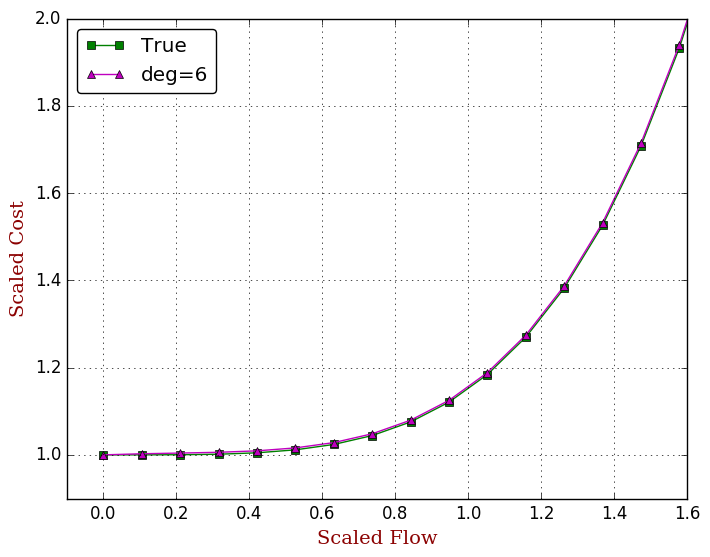

In [24]:
using PyPlot

true_coeffs = [1, 0, 0, 0, .15]

fcoeffs = coeffs_dict[(6, 3.41, 1.)]

xs = linspace(0, 2, 20)
zs_true = map(x->polyEval(true_coeffs, x), xs)

zs = map(x->polyEval(fcoeffs, x), xs)

plot(xs, zs_true, "s-g", label="True")

plot(xs, zs, "^-m", label="deg=6")
legend(loc="upper left",fancybox="true") 

grid("on")
xlim(-0.1, 1.6);
ylim(0.9, 2.0);

font1 = ["family"=>"serif",
    "color"=>"darkred",
    "weight"=>"normal",
    "size"=>14]
xlabel("Scaled Flow", fontdict=font1)
ylabel("Scaled Cost", fontdict=font1)

savefig("fitting_Sioux.pdf")